In [1]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


+ This notebook test the code to transform from correlation function to power spectrum.

In [3]:
# PSF preparation
ifield=1
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   4
nx          =   nrot 
ny          =   1
ndata       =   nx*ny
scale       =   0.168
ngridTot    =   ngrid*nx
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)

In [8]:
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
data_rows   =   []

# Get the  galaxy generator      
# Load data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   '/home/xiangchong/work/gw_ipmu/work/galsim_train/COSMOS_25.2_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)
# index
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
index       =   ifield%81400
record      =   param_cat[index]
# prepare the galaxies
gal0        =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
gal0        *=  flux_scaling
use_bulgefit=   record['use_bulgefit']
if use_bulgefit:
    bparams = record['bulgefit']
    gal_q   = bparams[3]
    gal_beta= bparams[7]*galsim.radians
    hlr     = record['hlr'][2]
    bulge_flux= record['flux'][1]
    disk_flux= record['flux'][2]
    flux    = (bulge_flux+disk_flux)*flux_scaling
else:
    sparams =   record['sersicfit']
    gal_q   =   sparams[3]
    gal_beta=   sparams[7]*galsim.radians
    hlr     =   record['hlr'][0]
    flux    =   record['flux'][0]*flux_scaling
# Get the SNR
fluxRadius  =   record['flux_radius']
snr         =   flux/fluxRadius/np.sqrt(np.pi)/np.sqrt(variance)
npoints     =   ud()*50+50
gal_not0    =   galsim.RandomWalk(half_light_radius=0.4,npoints=npoints,flux=flux)
gal_not0    =   gal_not0.shear(q=gal_q,beta=gal_beta)
for i in range(nrot):
    # Prepare the subimage
    ix      =   int(i%nx)
    iy      =   int(i/nx)
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    if i%nrot==0:
        # Get the galaxy image
        notRat  =   0.1#ud()*0.1
        gal     =   gal0*(1.-notRat)+gal_not0*notRat
        # Dilate the galaxy
        dilatS  =   1.+(ud()-0.5)*0.1
        gal     =   gal.dilate(dilatS)
        # Rotate the galaxy
        ang     =   ud()*2.*np.pi * galsim.radians
        gal     =   gal.rotate(ang)
        final   =   gal.shear(g1=g1,g2=g2)
    else:
        gal     =   gal.rotate(1./nrot*np.pi*galsim.radians)
        final   =   gal.shear(g1=g1,g2=g2)
    # Shear the galaxy
    final     =   galsim.Convolve([psfInt,final],gsparams=bigfft)
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel')

/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/galsim/deprecated/__init__.py:48: GalSimDeprecationWarning: RandomWalk has been deprecated since GalSim version 2.2.  Use RandomKnots instead.
  warnings.warn(s, GalSimDeprecationWarning)


In [5]:
corPre='corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)

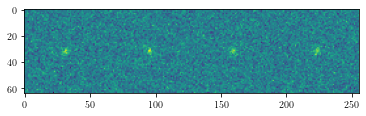

In [18]:
corNoise.applyTo(gal_image)
plt.imshow(gal_image.array)

In [43]:
corMea=np.zeros((ngrid,ngrid))
num=0
for i in range(1000):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    corMea+=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(noi_array))**2.)).real
    num+=1

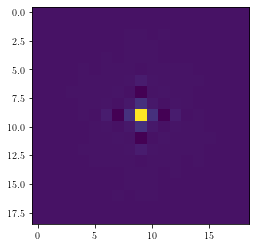

In [44]:
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corMea=corMea/corNum
corMea=corMea[ngrid//2-9:ngrid//2+10,ngrid//2-9:ngrid//2+10]/num
plt.imshow(corMea)

In [45]:
corIn=pyfits.getdata(corFname)*variance

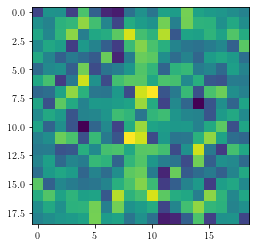

In [46]:
corRes=corMea-corIn
plt.imshow(corRes)

In [47]:
print(np.abs(corRes).max())

5.170749747952986e-06
